<div width=50% style="display: block; margin: auto">
    <img src="figures/ucl-logo.svg" width=100%>
</div>

### [UCL-ELEC0135 Applied Machine Learning Systems II - 2025]()
University College London
# Lab 2: Mixture of Experts


<hr width=70% style="float: left">

### Introduction

Mixture of experts (MoE) is a machine learning technique where multiple expert Neural Networks are used to divide a problem space into homogeneous regions. In this lab, we will use MoE in a classification task on [Cifar10](https://www.cs.toronto.edu/~kriz/cifar.html).

We will train a gating function to detect wether images are "natural images" (e.g. cat, dog, etc) or "artificial images" (e.g. plane, car). This gating functions will direct the samples to two deferent "expert" classifers, one trained to classify within the natural images catergory, and the other trained to classify within the artificial images catergory. Fianly, these experts will then used to boost the performance of a baseline 10 classes classiers.

All models (gating function, experts, and baseline classifers) will be [Convolutional Neural Networks (CNNs)](https://en.wikipedia.org/wiki/Convolutional_neural_network), a variant of the Multi Layers Perceptron (MLP) seen in lab 1 that uses [Convolutional layers](https://en.wikipedia.org/wiki/Convolutional_layer) and [Pooling layers](https://en.wikipedia.org/wiki/Pooling_layer) to automate feature extraction.

![](figures/moe_architecture_david.png)


### Intended Learning Outcome
* Define and train Convolutional Neural Networks with Tensorflow Keras.
* Use Layers and Wrappers to define and combine custom gate models.
* Compare the performances of a simple CNN classifier with a MoE classifier.


### Outline

This notebook has 4 parts:

0. [Setting up](#0.-Setting-up)
1. [Baseline 10 classes CNN](#1-baseline-10-classes-cnn)
2. [Experts CNNs](#2-experts-cnns)
3. [Integration of the models into a MoE](#3-gating-models)
4. [MoE](#4-moe)

<hr width=70% style="float: left">

# 0. Setting up

## 0.1 Importing librairies

<div class="alert alert-block alert-danger">
<b>👩‍💻👨‍💻 Action required</b>

- Make sure you are running this Notebook in the kernel of the virtual environment you created for this module.
- Run the following cell. If some packages have not been installed, add them to the requirements.txt file, and run in terminal (after having activated the virtual environment you created) the command `pip install -r requirements.txt`. 

</div>

In [1]:
# TODO: run this cell and add packages as needed
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import os
from sklearn.model_selection import train_test_split # called scikit-learn when importing with pip (in requirements.txt)
from sklearn.metrics import confusion_matrix
import seaborn as sns

2025-02-03 17:09:47.714737: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## 0.2 Importing the data

The [Cifar10](https://www.cs.toronto.edu/~kriz/cifar.html) dataset consists of 60000 32x32 colour images in 10 classes {0: airplane, 1: automobile, 2: bird, 3: cat, 4: deer, 5: dog, 6: frog, 7: horse, 8: ship, 9: truck}, with 6000 images per class. There are 50000 training images and 10000 test images.

![](figures/cifar10_resize.png)

<div class="alert alert-block alert-danger">
<b>👩‍💻👨‍💻 Action required</b>

- Run the cell bellow to import the cifar0 dataset, select a subset of the training and test set, and normalize the data.
- Print the number of samples in the training and test sets.
- Display the distribution of labels, is this dataset balanced?

</div>

In [2]:
# Load the CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

# Since the cifar dataset is quite large, we are only going to select a subset of smaller size to reduce the computational load required to finish this lab.
train_examples = 5000 # Max is 50000
test_examples = 1000   # Max is 5000

x_train = x_train[:train_examples] ; x_test = x_test[:test_examples]
y_train = y_train[:train_examples] ; y_test = y_test[:test_examples]

# Normalize pixel values to be between 0 and 1 (helps models converge faster)
x_train = x_train / 255.0
x_test = x_test / 255.0

# Convert class vectors to binary class matrices (one-hot encoding)
y_train0 = tf.keras.utils.to_categorical(y_train, 10)
y_test0 = tf.keras.utils.to_categorical(y_test, 10)

print("y train0:{0}\ny test0:{1}".format(y_train0.shape, y_test0.shape))

y train0:(5000, 10)
y test0:(1000, 10)


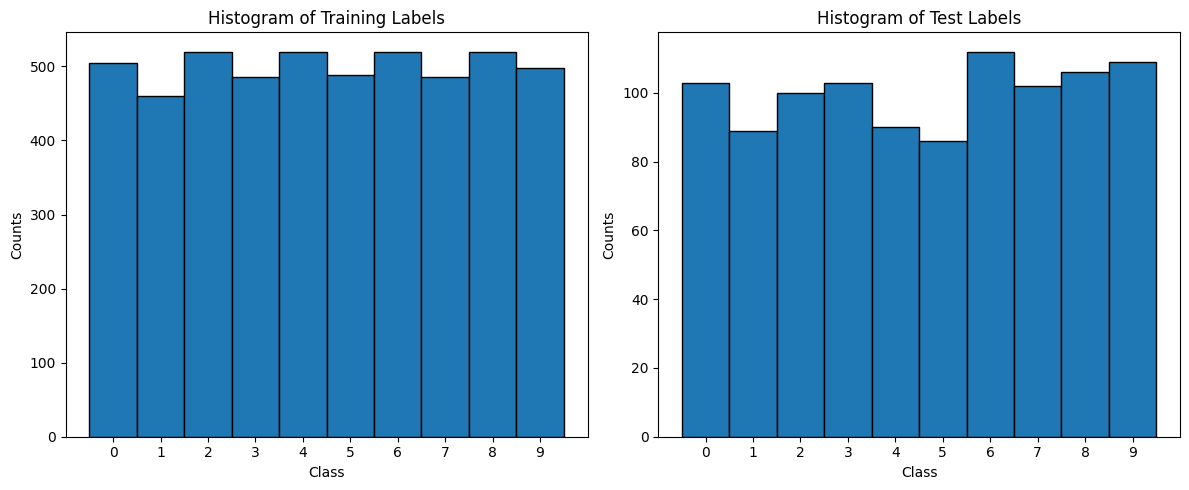

In [3]:
# TODO: your code here
# Plot histogram of labels in the training set
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(y_train, bins=np.arange(11) - 0.5, edgecolor='black')
plt.xticks(range(10))
plt.title('Histogram of Training Labels')
plt.xlabel('Class')
plt.ylabel('Counts')

# Plot histogram of labels in the test set
plt.subplot(1, 2, 2)
plt.hist(y_test, bins=np.arange(11) - 0.5, edgecolor='black')
plt.xticks(range(10))
plt.title('Histogram of Test Labels')
plt.xlabel('Class')
plt.ylabel('Counts')

plt.tight_layout()
plt.show()

# 1. Baseline 10 classes CNN

The baseline model and expert models will have the same CNN architecture, defined in the cell bellow. The large models should be more performent, but will require more training time.

In [4]:
# input layer

def CNN(n_classes = 10, large = False):
    """
    Create a Convolutional Neural Network for image classification

    Parameters:
        - n_classes (int): number of classes in the dataset
        - large (bool): whether to use a large or small model

    Returns:
        - model (tf.keras.models.Sequential): CNN model

    """
    if large:
        model = tf.keras.models.Sequential([
            # Convolutions and Pooling layers for feature extraction
            tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu', name='conv1.1', input_shape=(32, 32, 3))(input),
            tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu', name='conv1.2'),
            tf.keras.layers.MaxPooling2D((2, 2), name='pool1'),
            tf.keras.layers.Dropout(0.25, name='drop1'),
            tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu', name='conv2.1'),
            tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu', name='conv2.2'),
            tf.keras.layers.MaxPooling2D((2, 2), name='pool2'),
            tf.keras.layers.Dropout(0.25, name='drop2'),
            tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu', name='conv3.1'),
            tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu', name='conv3.2'),
            tf.keras.layers.MaxPooling2D((2, 2), name='pool3'),
            tf.keras.layers.Dropout(0.25, name='drop3'),

            # MLP for classification
            tf.keras.layers.Flatten(name='flatten'),
            tf.keras.layers.Dense(512, activation='relu', name='dense1'),
            tf.keras.layers.Dropout(0.5, name='drop4'),
            tf.keras.layers.Dense(n_classes, activation='softmax', name='output')
        ])

    else:
        model = tf.keras.models.Sequential([
            # Convolutions and Pooling layers for feature extraction
            tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu', name='conv1.1', input_shape=(32, 32, 3)),
            tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu', name='conv1.2'),
            tf.keras.layers.MaxPooling2D((2, 2), name='pool1'),
            tf.keras.layers.Dropout(0.25, name='drop1'),
            tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu', name='conv2.1'),
            tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu', name='conv2.2'),
            tf.keras.layers.MaxPooling2D((2, 2), name='pool2'),
            tf.keras.layers.Dropout(0.25, name='drop2'),

            # MLP for classification
            tf.keras.layers.Flatten(name='flatten'),
            tf.keras.layers.Dense(512, activation='relu', name='dense1'),
            tf.keras.layers.Dropout(0.5, name='drop3'),
            tf.keras.layers.Dense(n_classes, activation='softmax', name='output')
        ])

    return model

<div class="alert alert-block alert-danger">
<b>👩‍💻👨‍💻 Action required</b>

- Use the function above to create a baseline CNN.
- Compile the model, use the [ADAM optimizer](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam) with a learning rate of 0.00001, and the [categorical crossentropy](https://www.tensorflow.org/api_docs/python/tf/keras/losses/CategoricalCrossentropy) loss funtion.
- Use model.summary() to print a summary of your architecture.
- Train the model and display the confusion matrix on the test set. You can use the function ['confusion_matrix'](https://scikit-learn.org/dev/modules/generated/sklearn.metrics.confusion_matrix.html) from sklearn.

</div>

<div class="alert alert-block alert-info"> 
<b>💡 Tips</b> 

- Go back to lab 1 for a refresher on how to compile and train a model with tensorflow keras.

</div>

In [5]:
# TODO: your code here

baseline_model = CNN(large=False)
baseline_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
baseline_model.summary()

/Users/davidgerard/.local/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1.1 (Conv2D)                │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1.2 (Conv2D)                │ (None, 32, 32, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool1 (MaxPooling2D)            │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ drop1 (Dropout)                 │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2.1 (Conv2D)                │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2.2 (Conv2D)                │ (None, 16, 16, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool2 (MaxPooling2D)            │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ drop2 (Dropout)                 │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense1 (Dense)                  │ (None, 512)            │     2,097,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ drop3 (Dropout)                 │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 10)             │         5,130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,168,362 (8.27 MB)

 Trainable params: 2,168,362 (8.27 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 26s 141ms/step - accuracy: 0.2012 - loss: 2.1433 - val_accuracy: 0.3530 - val_loss: 1.7863
Epoch 2/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 38s 244ms/step - accuracy: 0.3422 - loss: 1.7708 - val_accuracy: 0.4410 - val_loss: 1.6250
Epoch 3/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 50s 315ms/step - accuracy: 0.4251 - loss: 1.5560 - val_accuracy: 0.4760 - val_loss: 1.4607
Epoch 4/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 33s 209ms/step - accuracy: 0.4722 - loss: 1.4756 - val_accuracy: 0.4640 - val_loss: 1.4353
Epoch 5/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 35s 167ms/step - accuracy: 0.5097 - loss: 1.3377 - val_accuracy: 0.5350 - val_loss: 1.2987
Epoch 6/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 19s 122ms/step - accuracy: 0.5479 - loss: 1.2219 - val_accuracy: 0.5160 - val_loss: 1.3785
Epoch 7/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 19s 120ms/step - accuracy: 0.5990 - loss: 1.1298 - val_accuracy: 0.5400 - val_loss: 1.2621
Epoch 8/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 19s 121ms/step - accuracy: 0.6413 - loss: 0

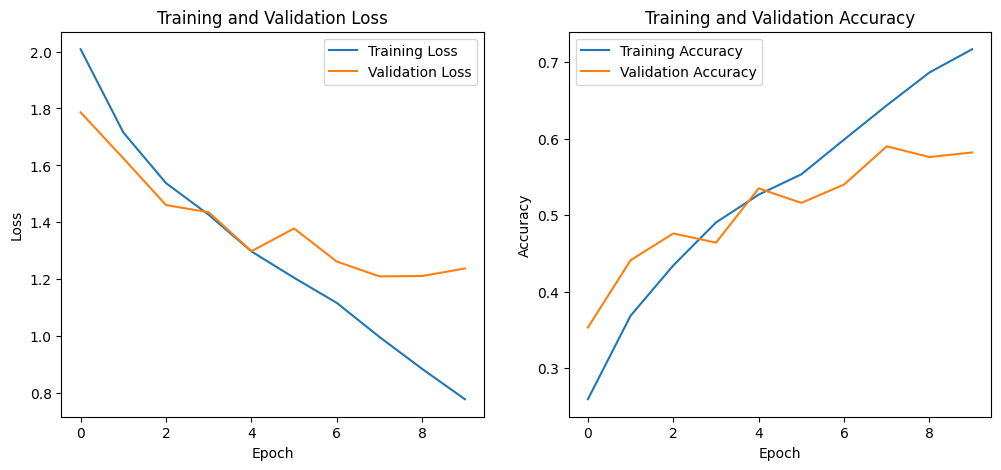

In [6]:
history = baseline_model.fit(x_train, y_train0,validation_data= (x_test,y_test0), epochs=10, batch_size=32)

# Plot the training and validation loss
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plot the training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step


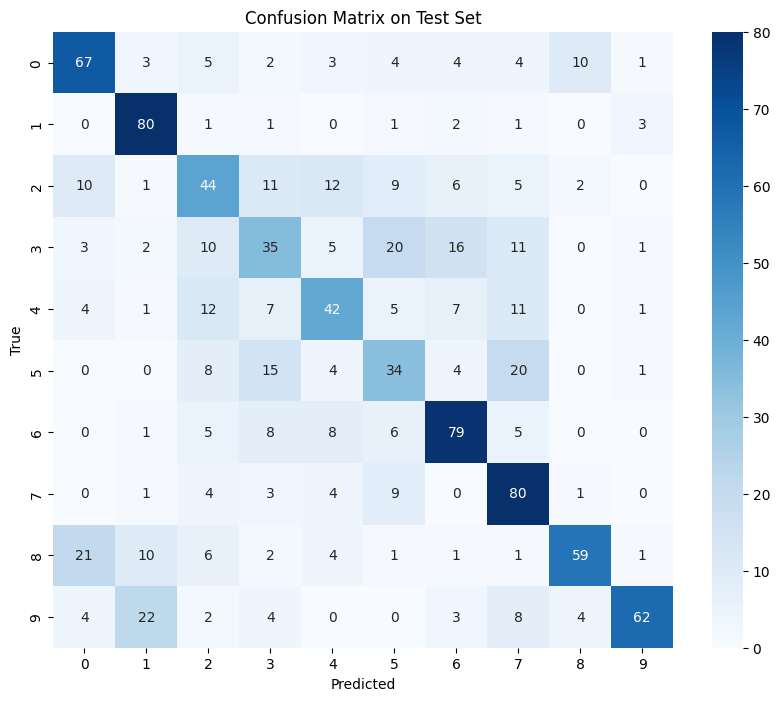

In [7]:
# Predict the labels for the test set
y_pred = baseline_model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(10), yticklabels=range(10))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix on Test Set')
plt.show()

# 2. Experts CNNs

## 2.1 Natural Images Expert CNN

<div class="alert alert-block alert-danger">
<b>👩‍💻👨‍💻 Action required</b>

- Use the function `CNN` defined in task 1 to create the Natural Images Expert.
- Compile the model, use the [ADAM optimizer](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam) with a learning rate of 0.00001, and the [categorical crossentropy](https://www.tensorflow.org/api_docs/python/tf/keras/losses/CategoricalCrossentropy) loss funtion.
- Use model.summary() to print a summary of your architecture.

</div>

In [8]:
# TODO: your code here

natural_expert_model = CNN(large=False)
natural_expert_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
natural_expert_model.summary()

/Users/davidgerard/.local/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1.1 (Conv2D)                │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1.2 (Conv2D)                │ (None, 32, 32, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool1 (MaxPooling2D)            │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ drop1 (Dropout)                 │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2.1 (Conv2D)                │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2.2 (Conv2D)                │ (None, 16, 16, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool2 (MaxPooling2D)            │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ drop2 (Dropout)                 │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense1 (Dense)                  │ (None, 512)            │     2,097,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ drop3 (Dropout)                 │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 10)             │         5,130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,168,362 (8.27 MB)

 Trainable params: 2,168,362 (8.27 MB)

 Non-trainable params: 0 (0.00 B)



<div class="alert alert-block alert-danger">
<b>👩‍💻👨‍💻 Action required</b>

- Create a subset of the training data containing all samples from the "artificial" classes (labels 2, 3, 4, 5, 6 and 7).
- Train the expert on the subset.
- Display 2 confusion matrices, one with the prediction results the test set when only including the "natural" classes, and one on the entire test set.

</div>

In [9]:
# TODO: your code here
natureTrain = [i for i in range(len(y_train)) if y_train[i] in [2,3,4,5,6,7]]
natureTest = [i for i in range(len(y_test)) if y_test[i] in [2,3,4,5,6,7]]

# for natural dataset
x_train_natural = x_train[natureTrain]
x_test_natural  = x_test[natureTest]
y_train_natural = y_train[natureTrain]
y_test_natural  = y_test[natureTest]


# one hot encoding
y_train0_natural = tf.keras.utils.to_categorical(y_train_natural, 10)
y_test0_natural = tf.keras.utils.to_categorical(y_test_natural, 10)

Epoch 1/10
95/95 ━━━━━━━━━━━━━━━━━━━━ 16s 133ms/step - accuracy: 0.1908 - loss: 1.8973 - val_accuracy: 0.3221 - val_loss: 1.6372
Epoch 2/10
95/95 ━━━━━━━━━━━━━━━━━━━━ 14s 152ms/step - accuracy: 0.3140 - loss: 1.6632 - val_accuracy: 0.3406 - val_loss: 1.5905
Epoch 3/10
95/95 ━━━━━━━━━━━━━━━━━━━━ 16s 167ms/step - accuracy: 0.3816 - loss: 1.5506 - val_accuracy: 0.4570 - val_loss: 1.4073
Epoch 4/10
95/95 ━━━━━━━━━━━━━━━━━━━━ 13s 136ms/step - accuracy: 0.4501 - loss: 1.4124 - val_accuracy: 0.4587 - val_loss: 1.3889
Epoch 5/10
95/95 ━━━━━━━━━━━━━━━━━━━━ 15s 161ms/step - accuracy: 0.4722 - loss: 1.3568 - val_accuracy: 0.4772 - val_loss: 1.3795
Epoch 6/10
95/95 ━━━━━━━━━━━━━━━━━━━━ 11s 111ms/step - accuracy: 0.5177 - loss: 1.2202 - val_accuracy: 0.5110 - val_loss: 1.2953
Epoch 7/10
95/95 ━━━━━━━━━━━━━━━━━━━━ 10s 110ms/step - accuracy: 0.5627 - loss: 1.1332 - val_accuracy: 0.4924 - val_loss: 1.3177
Epoch 8/10
95/95 ━━━━━━━━━━━━━━━━━━━━ 11s 112ms/step - accuracy: 0.5804 - loss: 1.1042 - val_accu

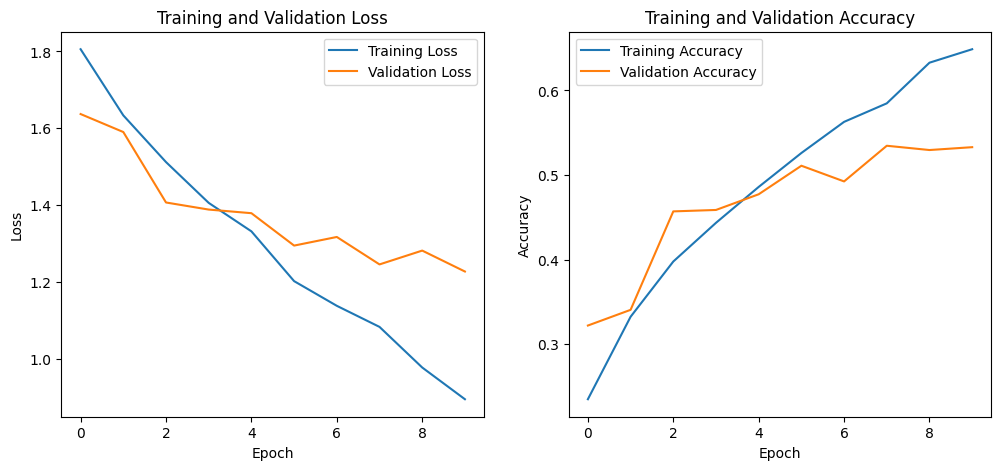

In [10]:
history = natural_expert_model.fit(x_train_natural, y_train0_natural,validation_data= (x_test_natural,y_test0_natural), epochs=10, batch_size=32)

# Plot the training and validation loss
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plot the training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step


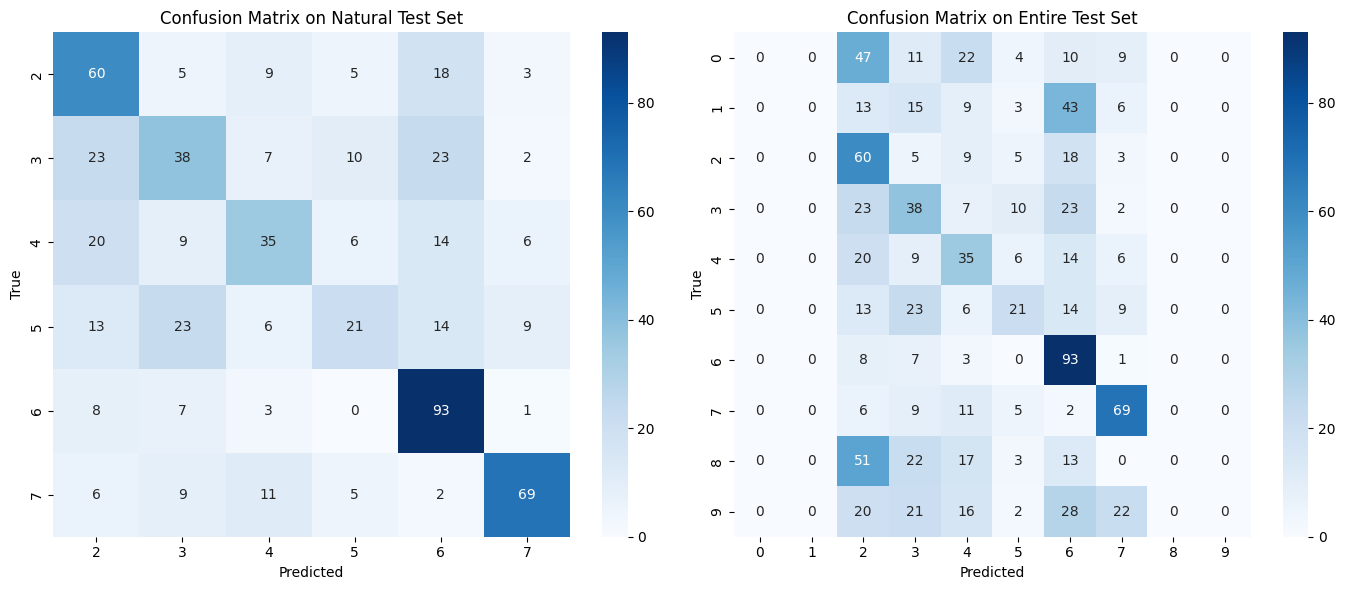

In [11]:
# Predict the labels for the natural test set
y_pred_natural = natural_expert_model.predict(x_test_natural)
y_pred_classes_natural = np.argmax(y_pred_natural, axis=1)

# Predict the labels for the entire test set
y_pred_all = natural_expert_model.predict(x_test)
y_pred_classes_all = np.argmax(y_pred_all, axis=1)

# Compute the confusion matrices
cm_natural = confusion_matrix(y_test_natural, y_pred_classes_natural)
cm_all = confusion_matrix(y_test, y_pred_classes_all)

# Plot the confusion matrices
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.heatmap(cm_natural, annot=True, fmt='d', cmap='Blues', xticklabels=[2,3,4,5,6,7], yticklabels=[2,3,4,5,6,7])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix on Natural Test Set')

plt.subplot(1, 2, 2)
sns.heatmap(cm_all, annot=True, fmt='d', cmap='Blues', xticklabels=range(10), yticklabels=range(10))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix on Entire Test Set')

plt.tight_layout()
plt.show()

## 2.2 Artificial Images Expert CNN

<div class="alert alert-block alert-danger">
<b>👩‍💻👨‍💻 Action required</b>

- Use the function `CNN` defined in task 1 to create the Artificial Images Expert.
- Compile the model, use the [ADAM optimizer](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam) with a learning rate of 0.00001, and the [categorical crossentropy](https://www.tensorflow.org/api_docs/python/tf/keras/losses/CategoricalCrossentropy) loss funtion.
- Use model.summary() to print a summary of your architecture.

</div>

In [12]:
# TODO: your code here

artificial_expert_model = CNN(large=False)
artificial_expert_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
artificial_expert_model.summary()

/Users/davidgerard/.local/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1.1 (Conv2D)                │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1.2 (Conv2D)                │ (None, 32, 32, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool1 (MaxPooling2D)            │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ drop1 (Dropout)                 │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2.1 (Conv2D)                │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2.2 (Conv2D)                │ (None, 16, 16, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool2 (MaxPooling2D)            │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ drop2 (Dropout)                 │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense1 (Dense)                  │ (None, 512)            │     2,097,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ drop3 (Dropout)                 │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 10)             │         5,130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,168,362 (8.27 MB)

 Trainable params: 2,168,362 (8.27 MB)

 Non-trainable params: 0 (0.00 B)

<div class="alert alert-block alert-danger">
<b>👩‍💻👨‍💻 Action required</b>

- Create a subset of the training data containing all samples from the "artificial" classes labels 0, 1, 8 and 9.
- Train the expert on the subset.
- Display 2 confusion matrices, one with the prediction results the test set when only including the "natural" classes, and one on the entire test set.

</div>

In [13]:
# TODO: your code here
artTrain = [i for i in range(len(y_train)) if y_train[i] in [0,1,8,9]]
artTest = [i for i in range(len(y_test)) if y_test[i] in [0,1,8,9]]

x_train_artificial = x_train[artTrain]
x_test_artificial = x_test[artTest]
y_train_artificial = y_train[artTrain]
y_test_artificial= y_test[artTest]

# one hot encoding
y_train0_artificial = tf.keras.utils.to_categorical(y_train_artificial, 10)
y_test0_artificial = tf.keras.utils.to_categorical(y_test_artificial, 10)

Epoch 1/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 11s 117ms/step - accuracy: 0.3038 - loss: 1.5033 - val_accuracy: 0.5258 - val_loss: 1.1396
Epoch 2/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 7s 110ms/step - accuracy: 0.5138 - loss: 1.1118 - val_accuracy: 0.5258 - val_loss: 1.0447
Epoch 3/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 7s 111ms/step - accuracy: 0.5574 - loss: 1.0039 - val_accuracy: 0.6216 - val_loss: 0.9495
Epoch 4/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 7s 110ms/step - accuracy: 0.6075 - loss: 0.8922 - val_accuracy: 0.6216 - val_loss: 0.8783
Epoch 5/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 7s 108ms/step - accuracy: 0.6515 - loss: 0.8024 - val_accuracy: 0.6462 - val_loss: 0.8504
Epoch 6/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 7s 121ms/step - accuracy: 0.7123 - loss: 0.7296 - val_accuracy: 0.6953 - val_loss: 0.7429
Epoch 7/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 9s 143ms/step - accuracy: 0.7339 - loss: 0.6489 - val_accuracy: 0.6486 - val_loss: 0.8357
Epoch 8/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 9s 145ms/step - accuracy: 0.7660 - loss: 0.6096 - val_accuracy: 0

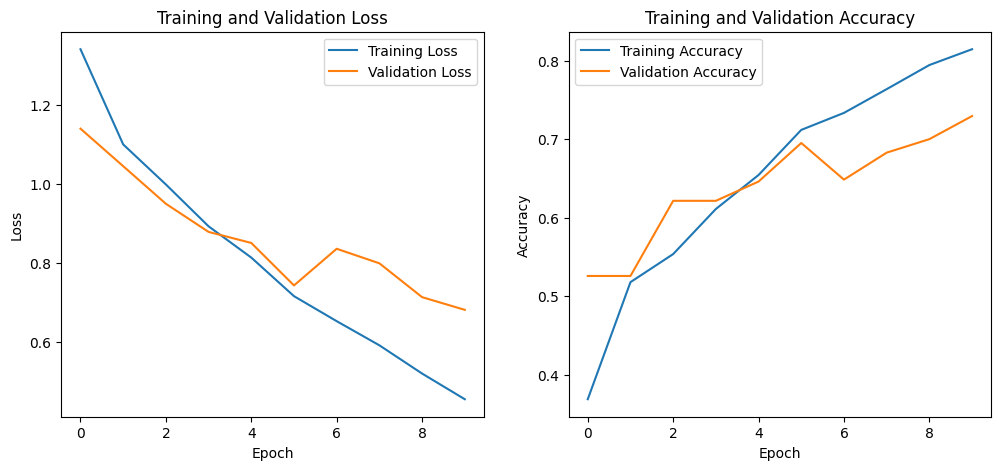

In [14]:
history = artificial_expert_model.fit(x_train_artificial, y_train0_artificial,validation_data= (x_test_artificial,y_test0_artificial), epochs=10, batch_size=32)

# Plot the training and validation loss
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plot the training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()


13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step


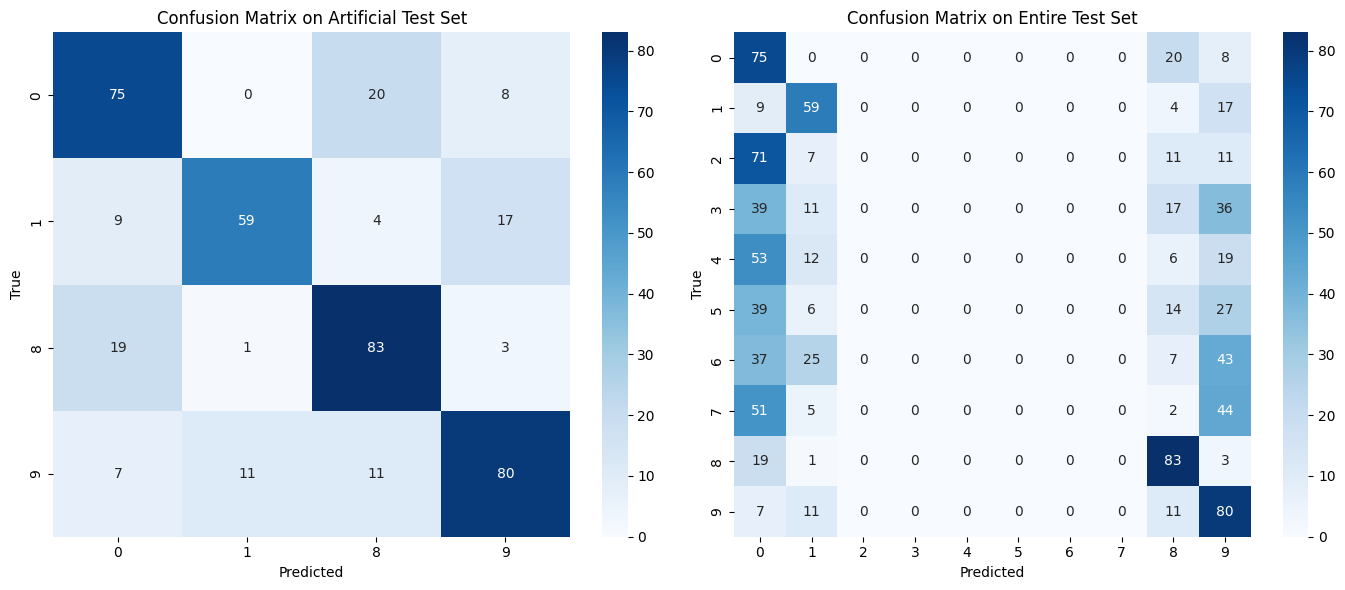

In [15]:
# Predict the labels for the artificial test set
y_pred_artificial = artificial_expert_model.predict(x_test_artificial)
y_pred_classes_artificial = np.argmax(y_pred_artificial, axis=1)

# Predict the labels for the entire test set
y_pred_all = artificial_expert_model.predict(x_test)
y_pred_classes_all = np.argmax(y_pred_all, axis=1)

# Compute the confusion matrices
cm_artificial = confusion_matrix(y_test_artificial, y_pred_classes_artificial)
cm_all = confusion_matrix(y_test, y_pred_classes_all)

# Plot the confusion matrices
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.heatmap(cm_artificial, annot=True, fmt='d', cmap='Blues', xticklabels=[0,1,8,9], yticklabels=[0,1,8,9])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix on Artificial Test Set')

plt.subplot(1, 2, 2)
sns.heatmap(cm_all, annot=True, fmt='d', cmap='Blues', xticklabels=range(10), yticklabels=range(10))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix on Entire Test Set')

plt.tight_layout()
plt.show()

# 3. Gating models

## 3.1 Gating Natural / Artificial images Experts

The first gating model will take as input an image from the cifar dataset, and decide which expert to use. In other words, it's a binairy classifier trained to know if an image falls into the "natural" or "artificial" category.

<div class="alert alert-block alert-danger">
<b>👩‍💻👨‍💻 Action required</b>

- For the training and test set, create new labels that indicate wether the samples are "natural" objects or "artificial" objects. Use one-hot encoding (see code in task 0.2 for reference).
- Use the function `CNN` defined in task 1 to create a gating binary classfifier.
- Use model.summary() to print a summary of your architecture.
- Train the model and display the confusion matrix on the test set.


</div>

In [16]:
# TODO: your code here

expert_choice_gate = CNN(n_classes=2, large=False)
expert_choice_gate.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
expert_choice_gate.summary()

/Users/davidgerard/.local/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1.1 (Conv2D)                │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1.2 (Conv2D)                │ (None, 32, 32, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool1 (MaxPooling2D)            │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ drop1 (Dropout)                 │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2.1 (Conv2D)                │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2.2 (Conv2D)                │ (None, 16, 16, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool2 (MaxPooling2D)            │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ drop2 (Dropout)                 │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense1 (Dense)                  │ (None, 512)            │     2,097,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ drop3 (Dropout)                 │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 2)              │         1,026 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,164,258 (8.26 MB)

 Trainable params: 2,164,258 (8.26 MB)

 Non-trainable params: 0 (0.00 B)

In [17]:
y_train_type = np.array([0 if y in [2,3,4,5,6,7] else 1 for y in y_train])
y_test_type = np.array([0 if y in [2,3,4,5,6,7] else 1 for y in y_test])

y_train0_type = tf.keras.utils.to_categorical(y_train_type, 2)
y_test0_type = tf.keras.utils.to_categorical(y_test_type, 2)

Epoch 1/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 30s 160ms/step - accuracy: 0.6898 - loss: 0.5823 - val_accuracy: 0.8630 - val_loss: 0.3118
Epoch 2/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 24s 154ms/step - accuracy: 0.8507 - loss: 0.3568 - val_accuracy: 0.8980 - val_loss: 0.2692
Epoch 3/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 29s 187ms/step - accuracy: 0.8793 - loss: 0.2880 - val_accuracy: 0.8900 - val_loss: 0.2673
Epoch 4/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 22s 139ms/step - accuracy: 0.8791 - loss: 0.2792 - val_accuracy: 0.8750 - val_loss: 0.2971
Epoch 5/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 28s 181ms/step - accuracy: 0.8916 - loss: 0.2594 - val_accuracy: 0.8940 - val_loss: 0.2571
Epoch 6/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 30s 188ms/step - accuracy: 0.9117 - loss: 0.2326 - val_accuracy: 0.9160 - val_loss: 0.2340
Epoch 7/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 27s 173ms/step - accuracy: 0.9188 - loss: 0.2057 - val_accuracy: 0.9050 - val_loss: 0.2342
Epoch 8/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 26s 163ms/step - accuracy: 0.9206 - loss: 0

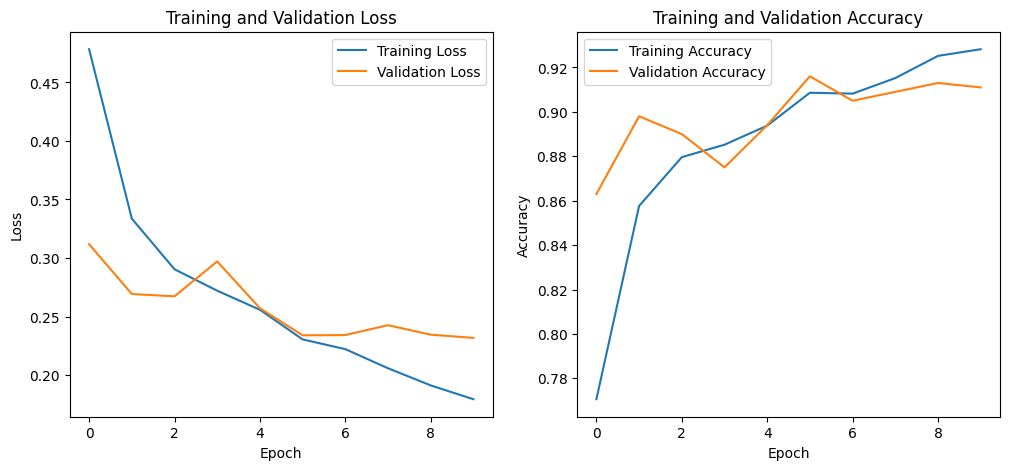

In [18]:
history = expert_choice_gate.fit(x_train, y_train0_type,validation_data= (x_test,y_test0_type), epochs=10, batch_size=32)

# Plot the training and validation loss
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plot the training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step


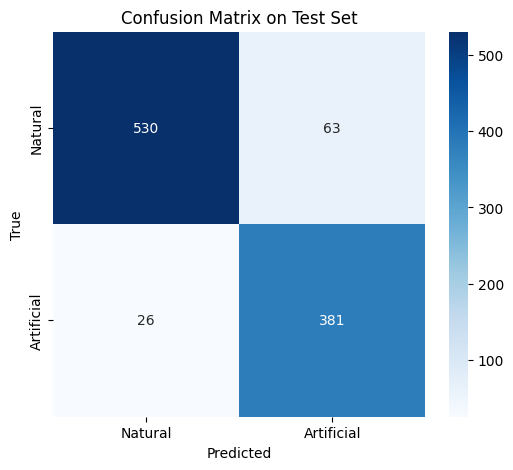

In [19]:
# Predict the labels for the test set
y_pred_type = expert_choice_gate.predict(x_test)
y_pred_classes_type = np.argmax(y_pred_type, axis=1)

# Compute the confusion matrix
cm_type = confusion_matrix(y_test_type, y_pred_classes_type)

# Plot the confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm_type, annot=True, fmt='d', cmap='Blues', xticklabels=['Natural', 'Artificial'], yticklabels=['Natural', 'Artificial'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix on Test Set')
plt.show()

## 3.2 Gating Baseline / Experts

We now have a baseline classifier (10 classes CNN), 2 experts classifiers (10 classes but specialise in classifying either the natural or artificial categories), and a gating classfier (2 classes CNN) which decides which of the experts to choose for the given input. 

We now want our second gate to be able to take in the cifar input and weighs the importance of the output of the baseline and the selected expert in producing a final MoE output prediction. To do this, the second gate will be composed of 2 sub-gates, one for each expert model. 

Each gate will use an importance model that will output values for the i) baseline and ii) chosen expert, i.e. what the sub-gate 'thinks' the realtive importance of the 10 baseline classifier and the relative importance is of the expert are.

**Importance model:**
1. Flatten Layer 
2. Dense layer with 512 neurons and relu activation function
3. Dropout layer with dropout rate of 0.5
4. Dense layer with 2*the number of classes and softmax activation functions
5. Reshape layer that reshapes the output to (number of classes, 2)

<div class="alert alert-block alert-danger">
<b>👩‍💻👨‍💻 Action required</b>

- Implement the function `importance_model` to create a model with the arcitecture described above.
- Create 2 sub gate models, one for the "natural" expert and one for the "artificial" expert.

</div>

In [20]:
def importance_model(n_classes=10):
    model = tf.keras.models.Sequential([
        tf.keras.layers.Flatten(input_shape=(32, 32, 3)),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(n_classes*2, activation='softmax'),
        tf.keras.layers.Reshape((n_classes, 2))
    ])
    return model

artificial_importance_model = importance_model()
natural_importance_model = importance_model()

artificial_importance_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
natural_importance_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

/Users/davidgerard/.local/lib/python3.11/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Now we can implement the subgate as a model that:

- Takes in argument gx, which is a list of 3 tensors: 
    - gx[0] -> baseline output tensor (10,). Is a softmax output for each of the 10 classes
    - gx[1] -> expert network output tensor (10,). Is a softmax output for each of the 10 classes. Which expert's output reached here depends on the binary classifier output of the first gate (we will implement the logic of choosing the expert when we integrate all the models together, see below).
    - the corresponding importance of each models
    - gx[2] -> corresponding importance model output tensor (10,2,). 
        - gx[2][:,:,0] -> baseline importance tensor of shape (10,) i.e what the sub-gate thinks the importance is of each of the 10 baseline output classes. 
        - gx[2][:,:,1] -> expert importance tensor of shape (10,) i.e what the sub-gate thinks the importance is of each of the 10 expert output classes.

- Performs the following:
    - Multiplies the baseline's output by the sub-gate's baseline importance -> (10,) tensor.
    - Multiplies the expert's output by the sub-gate's expert importance -> (10,) tensor 
    - Sums these two importance-weighted terms to get a final (10,) tensor of logit outputs (one for each class) -> (10,) tensor.

To implement the subgate, we use a [`tf.keras.layers.Lamdba`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Lambda) layer, itself using a [lambda](https://www.w3schools.com/python/python_lambda.asp) object.

In [21]:
def subgate(baseline_model, expert_model, importance_model, n_classes=10):
    output = tf.keras.layers.Lambda(
        lambda gx: (gx[0]*gx[2][:,:,0]) + (gx[1]*gx[2][:,:,1]), output_shape=(n_classes,)
        )([baseline_model, expert_model, importance_model])
    return output

# 4. MoE

At this stage, we have implemented:
- A baseline 10 classes classifier.
- 2 experts 10 classes classifiers.
- A binairy classifier that will be used to choose which expert to use.
- Subgates that weighs the importance of the output of the baseline and the selected expert in producing a final MoE output prediction using an importance model.

We now need to implement the logic deciding which expert to use, and integrate all the different components of our MoE together in order to be able to train the whole architecture at once.

<div class="alert alert-block alert-info"> 
<b>💡 Tips</b> 

- The advantage of using a framework like Tensorflow Keras is that all the layers are inheritted from the same abstract classes, meaning that as long as we use classes and wrappers properly, and that input and output shapes of the components models match, the resulting model will be trainable using the same tools as the individual component models. This spares us extensive and complicated gradiant calculations.

</div>


<div class="alert alert-block alert-danger">
<b>👩‍💻👨‍💻 Action required</b>

- Using a [`tf.keras.layers.Lamdba`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Lambda) layer and [`tf.where`](https://www.tensorflow.org/api_docs/python/tf/where) in a similar manner as the implementation of the function `subgate`, implement a model that:
    - Takes in argument gx, which is a list of 6 tensors:
        - gx[0] -> baseline output tensor (10,)
        - gx[1] -> first gate binary output tensor (2,)
        - gx[2] -> artificial expert output tensor (10,)
        - gx[3] -> natural expert output tensor (10,)
        - gx[4] -> artificial importance model output tensor (10,2,)
        - gx[5] -> natural importance model output tensor (10,2,)
    - If the binairy classifier classifies the image as artificial (`switch(tf.expand_dims(gx[1][:,0],axis=1) > tf.expand_dims(gx[1][:,1],axis=1)`):
        - Outputs the results of the artificial subgate model (10,2,)
    - Else:
        - Outputs the results of the natural subgate model (10,2,)

- Compile the model, use the [ADAM optimizer](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam) with a learning rate of 0.00001, and the [categorical crossentropy](https://www.tensorflow.org/api_docs/python/tf/keras/losses/CategoricalCrossentropy) loss funtion.
- Use model.summary() to print a summary of your architecture.
- Train the model and display the confusion matrix on the test set. Compare performances with the baseline classifier alone.
    - Have the performances been improved?
    - Is the increased model complexity and training time worth the accuracy gains?

</div>




In [ ]:
def MoE(baseline_model, expert_choice_gate, artificial_expert_model, natural_expert_model, artificial_importance_model, natural_importance_model):
    """
    Create a Mixture of Experts model for image classification

    Args:
        - baseline_model (tf.keras.models.Sequential): baseline CNN model
        - expert_choice_gate (tf.keras.models.Sequential): expert choice gate model
        - artificial_expert_model (tf.keras.models.Sequential): artificial expert model
        - natural_expert_model (tf.keras.models.Sequential): natural expert model
        - artificial_importance_model (tf.keras.models.Sequential): artificial importance model
        - natural_importance_model (tf.keras.models.Sequential): natural importance model

    Returns:
        - model (tf.keras.models.Model): MoE model

    """
    # Define input tensor
    inputs = tf.keras.layers.Input(shape=(32, 32, 3))

    # Get baseline predictions
    baseline_output = baseline_model(inputs)
    
    # Get expert choice gate predictions
    expert_gate_output = expert_choice_gate(inputs)

    # Get expert predictions
    artificial_expert_output = artificial_expert_model(inputs)
    natural_expert_output = natural_expert_model(inputs)

    # Get importance model outputs
    artificial_importance_output = artificial_importance_model(inputs)
    natural_importance_output = natural_importance_model(inputs)

    # Condition selection: If expert_choice_gate prefers artificial expert, use it, else use natural expert
    def moe_logic(gx):
        """
        Mixture of Experts logic, selecting the expert output based on the expert choice gate
        
        Args:
            - gx (list): list of tensors containing expert_choice, baseline, artificial_expert, natural_expert, artificial_importance, natural_importance
            
        Returns:
            - selected_expert_output (tf.Tensor): selected expert output
        """
        expert_choice, base_out, art_exp_out, nat_exp_out, art_imp_out, nat_imp_out = gx
        condition = tf.expand_dims(expert_choice[:, 0], axis=1) > tf.expand_dims(expert_choice[:, 1], axis=1)
        
        selected_expert_output = tf.where(condition, 
                                          subgate(base_out, art_exp_out, art_imp_out), 
                                          subgate(base_out, nat_exp_out, nat_imp_out))
        return selected_expert_output

    # MoE decision layer using Lambda
    # TODO: your code here
    output = tf.keras.layers.Lambda(moe_logic, output_shape=(10,) )([
        expert_gate_output, baseline_output, artificial_expert_output, 
        natural_expert_output, artificial_importance_output, natural_importance_output
    ])

    # Build the final model
    model = tf.keras.Model(inputs=inputs, outputs=output)
    return model

# TODO: your code here
# Create MoE model
moe_model = MoE(baseline_model, expert_choice_gate, artificial_expert_model, natural_expert_model, artificial_importance_model, natural_importance_model)
moe_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Summary
moe_model.summary()



Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6       │ (None, 32, 32, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_3        │ (None, 2)         │  2,164,258 │ input_layer_6[0]… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential          │ (None, 10)        │  2,168,362 │ input_layer_6[0]… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_2        │ (None, 10)        │  2,168,362 │ input_layer_6[0]… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_1        │ (None, 10)        │  2,168,362 │ input_layer_6[0]… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_4        │ (None, 10, 2)     │  1,583,636 │ input_layer_6[0]… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_5        │ (None, 10, 2)     │  1,583,636 │ input_layer_6[0]… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda (Lambda)     │ (None, 10)        │          0 │ sequential_3[0][… │
│                     │                   │            │ sequential[0][0], │
│                     │                   │            │ sequential_2[0][… │
│                     │                   │            │ sequential_1[0][… │
│                     │                   │            │ sequential_4[0][… │
│                     │                   │            │ sequential_5[0][… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 11,836,616 (45.15 MB)

 Trainable params: 11,836,616 (45.15 MB)

 Non-trainable params: 0 (0.00 B)

In [23]:
moe_model.fit(x_train, y_train0, validation_data=(x_test, y_test0), epochs=10, batch_size=32)

Epoch 1/10


/Users/davidgerard/.local/lib/python3.11/site-packages/keras/src/optimizers/base_optimizer.py:774: UserWarning: Gradients do not exist for variables ['sequential_3/conv1.1/kernel', 'sequential_3/conv1.1/bias', 'sequential_3/conv1.2/kernel', 'sequential_3/conv1.2/bias', 'sequential_3/conv2.1/kernel', 'sequential_3/conv2.1/bias', 'sequential_3/conv2.2/kernel', 'sequential_3/conv2.2/bias', 'sequential_3/dense1/kernel', 'sequential_3/dense1/bias', 'sequential_3/output/kernel', 'sequential_3/output/bias'] when minimizing the loss. If using `model.compile()`, did you forget to provide a `loss` argument?
  warnings.warn(


157/157 ━━━━━━━━━━━━━━━━━━━━ 97s 507ms/step - accuracy: 0.6434 - loss: 1.5715 - val_accuracy: 0.5940 - val_loss: 1.3816
Epoch 2/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 75s 480ms/step - accuracy: 0.8064 - loss: 0.5793 - val_accuracy: 0.6100 - val_loss: 1.3406
Epoch 3/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 75s 480ms/step - accuracy: 0.8269 - loss: 0.5075 - val_accuracy: 0.5950 - val_loss: 1.3341
Epoch 4/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 76s 483ms/step - accuracy: 0.8367 - loss: 0.4755 - val_accuracy: 0.5970 - val_loss: 1.4562
Epoch 5/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 80s 469ms/step - accuracy: 0.8547 - loss: 0.4172 - val_accuracy: 0.5870 - val_loss: 1.4473
Epoch 6/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 68s 431ms/step - accuracy: 0.8772 - loss: 0.3620 - val_accuracy: 0.6000 - val_loss: 1.5529
Epoch 7/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 72s 458ms/step - accuracy: 0.8763 - loss: 0.3416 - val_accuracy: 0.5970 - val_loss: 1.6504
Epoch 8/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 76s 482ms/step - accuracy: 0.8829 - loss: 0.3217 - val

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 140ms/step
Baseline Model Accuracy: 60.20%
MoE Model Accuracy: 61.00%


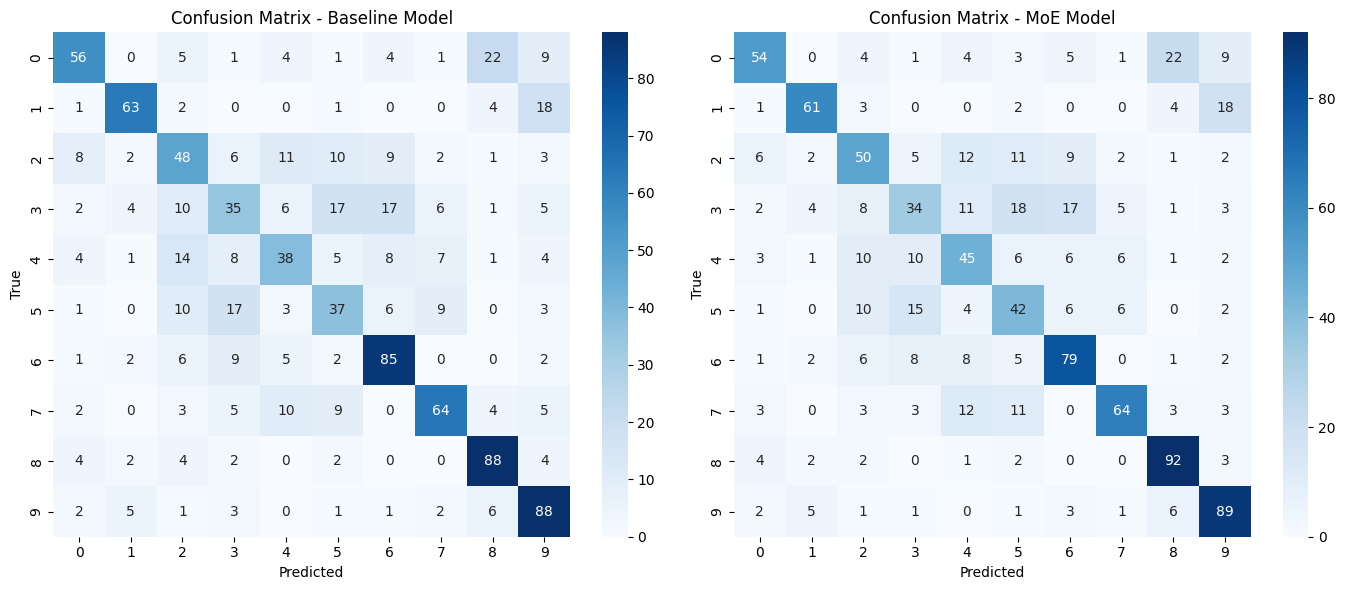

In [24]:
# Predict the labels for the test set using the baseline model
y_pred_baseline = baseline_model.predict(x_test)
y_pred_classes_baseline = np.argmax(y_pred_baseline, axis=1)

# Predict the labels for the test set using the MoE model
y_pred_moe = moe_model.predict(x_test)
y_pred_classes_moe = np.argmax(y_pred_moe, axis=1)

# Compute the confusion matrices
cm_baseline = confusion_matrix(y_test, y_pred_classes_baseline)
cm_moe = confusion_matrix(y_test, y_pred_classes_moe)

# Calculate accuracy
accuracy_baseline = np.sum(y_pred_classes_baseline == y_test.flatten()) / len(y_test)
accuracy_moe = np.sum(y_pred_classes_moe == y_test.flatten()) / len(y_test)

# Print accuracy
print(f"Baseline Model Accuracy: {accuracy_baseline * 100:.2f}%")
print(f"MoE Model Accuracy: {accuracy_moe * 100:.2f}%")

# Plot the confusion matrices side by side
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.heatmap(cm_baseline, annot=True, fmt='d', cmap='Blues', xticklabels=range(10), yticklabels=range(10))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - Baseline Model')

plt.subplot(1, 2, 2)
sns.heatmap(cm_moe, annot=True, fmt='d', cmap='Blues', xticklabels=range(10), yticklabels=range(10))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - MoE Model')

plt.tight_layout()
plt.show()